In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_context("poster")

import torch
from torch import nn as nn
ttype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
ctype = torch.cuda.LongTensor if torch.cuda.is_available() else torch.LongTensor
print(ttype)
import torch.nn.functional as F
from matplotlib import gridspec
from sithcon import SITHCon_Layer, _SITHCon_Core, iSITH

from tqdm.notebook import tqdm

import itertools
from csv import DictWriter
import os 
from os.path import join
import glob

import numpy as np
import pandas as pd
import pickle
from math import factorial
import random

<class 'torch.cuda.FloatTensor'>


In [3]:
MORSE_CODE_DICT = {'1':'.----', '2':'..---', '3':'...--', 
                    '4':'....-', '5':'.....', '6':'-....', 
                    '7':'--...', '8':'---..', '9':'----.', 
                    '0':'-----', } 

# SHORTER
MORSE_CODE_DICT = {'1':'.-', '2':'-...', 
                    '3':'-.-.', '4':'-..', '5':'.', 
                    '6':'..-.', '7':'--.', '8':'....', 
                    '9':'..', '0':'.---',}

In [4]:

print()
morse_code_numpy = {key:np.array([int(x) for x in MORSE_CODE_DICT[key].replace('.', '10').replace('-', '1110')] + [0, 0])
                    for key in MORSE_CODE_DICT.keys()}
for k in morse_code_numpy.keys():
    print(morse_code_numpy[k], k)
subset = list(morse_code_numpy.keys())



[1 0 1 1 1 0 0 0] 1
[1 1 1 0 1 0 1 0 1 0 0 0] 2
[1 1 1 0 1 0 1 1 1 0 1 0 0 0] 3
[1 1 1 0 1 0 1 0 0 0] 4
[1 0 0 0] 5
[1 0 1 0 1 1 1 0 1 0 0 0] 6
[1 1 1 0 1 1 1 0 1 0 0 0] 7
[1 0 1 0 1 0 1 0 0 0] 8
[1 0 1 0 0 0] 9
[1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0] 0


(480, 2)


Text(0.5, 1.0, '0.7000000000000001')

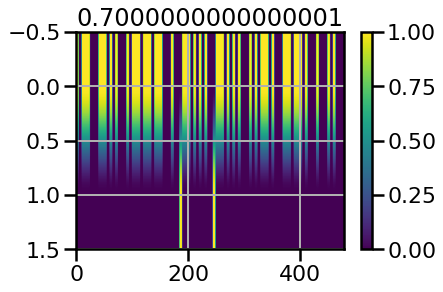

In [9]:
def gen_item(samples=10, complexity=2, scale=5, target_scale=.1):
    # We can tests 1s the same length as the items added together or 1 at the end only.
    keys = morse_code_numpy.keys()
    dim1 = []
    dim2 = []
    
    added_indexes = np.random.randint(samples, size=complexity)
    
    answer = 0
    for s in range(samples):
        
        # Grab Random Morse Code Letter
        k = random.sample(keys, 1)[0]
        mcl = morse_code_numpy[k]
        Mmcl = mcl.repeat(scale)
        dim1.append(Mmcl[:, np.newaxis])
        if s in added_indexes:
            
            # dim2.append(np.ones(Mmcl.shape[0])[:, np.newaxis])
            temp = np.zeros(Mmcl.shape[0])[:, np.newaxis]
            temp[-scale:] = 1.0
            # temp[-1:] = 1.0 # TRY THIS AT SOME POINT
            dim2.append(temp)
            answer += int(k)
        else:
            dim2.append(np.zeros(Mmcl.shape[0])[:, np.newaxis])
    inp = np.concatenate([np.concatenate(dim1, axis=0),
                          np.concatenate(dim2, axis=0)], axis=1)
    
    target = np.array([answer])
    return inp, target*target_scale
inp, tar = gen_item(10, 2, 5)
print(inp.shape)
plt.imshow(inp.T,aspect='auto')
plt.grid()
plt.colorbar()
plt.title(tar[0])

In [6]:
class SITHCon_Classifier(nn.Module):
    def __init__(self, out_classes, layer_params, 
                 act_func=nn.ReLU, batch_norm=False,
                 dropout=.2):
        super(SITHCon_Classifier, self).__init__()
        last_channels = layer_params[-1]['channels']
        self.transform_linears = nn.ModuleList([nn.Linear(l['channels'], l['channels'])
                                                for l in layer_params])
        self.sithcon_layers = nn.ModuleList([SITHCon_Layer(l, act_func) for l in layer_params])
        self.to_out = nn.Linear(last_channels, out_classes)
        
        
    def forward(self, inp):
        
        x = inp
        #out = []
        for i in range(len(self.sithcon_layers)):
            x = self.sithcon_layers[i](x)
            
            x = self.transform_linears[i](x[:,0,:,:].transpose(1,2))
            x = x.unsqueeze(1).transpose(2,3)

            #out.append(x.clone())
        x = x.transpose(2,3)[:, 0, :, :]
        #x = x.transpose(2,3)[:, 0, :, :]
        x = self.to_out(x)
        return x

# Three Layers

In [7]:
sp1 = dict(in_features=2, 
           tau_min=.1, tau_max=1000.0, buff_max=2000,
           dt=1, ntau=500, k=30, g=0.0, ttype=ttype, 
           channels=25, kernel_width=20, dilation=4,
           dropout=None, batch_norm=None)
sp2 = dict(in_features=sp1['channels'], 
           tau_min=.1, tau_max=1000.0, buff_max=2000,
           dt=1, ntau=500, k=30, g=0.0, ttype=ttype, 
           channels=25, kernel_width=20, dilation=4, 
           dropout=None, batch_norm=None)
sp3 = dict(in_features=sp2['channels'], 
           tau_min=.1, tau_max=1000.0, buff_max=2000,
           dt=1, ntau=500, k=30, g=0.0, ttype=ttype, 
           channels=25, kernel_width=20, dilation=4, 
           dropout=None, batch_norm=None)
layer_params = [sp1, sp2, sp3]

model = SITHCon_Classifier(1, layer_params, act_func=nn.ReLU).cuda()
model
tot_weights = 0
for p in model.parameters():
    tot_weights += p.numel()
print("Total Weights:", tot_weights)
print(model)

Total Weights: 28051
SITHCon_Classifier(
  (transform_linears): ModuleList(
    (0): Linear(in_features=25, out_features=25, bias=True)
    (1): Linear(in_features=25, out_features=25, bias=True)
    (2): Linear(in_features=25, out_features=25, bias=True)
  )
  (sithcon_layers): ModuleList(
    (0): SITHCon_Layer(
      (sithcon): _SITHCon_Core(
        (sith): iSITH(ntau=500, tau_min=0.1, tau_max=1000.0, buff_max=2000, dt=1, k=30, g=0.0)
        (conv): Conv2d(1, 25, kernel_size=(2, 20), stride=(1, 1), dilation=(1, 4), bias=False)
        (maxp): MaxPool1d(kernel_size=424, stride=424, padding=0, dilation=1, ceil_mode=False)
      )
      (act_func): ReLU()
    )
    (1): SITHCon_Layer(
      (sithcon): _SITHCon_Core(
        (sith): iSITH(ntau=500, tau_min=0.1, tau_max=1000.0, buff_max=2000, dt=1, k=30, g=0.0)
        (conv): Conv2d(1, 25, kernel_size=(25, 20), stride=(1, 1), dilation=(1, 4), bias=False)
        (maxp): MaxPool1d(kernel_size=424, stride=424, padding=0, dilation=1, cei

In [10]:
iv = inp
iv = ttype(iv).unsqueeze(0).unsqueeze(0).transpose(-1,-2)
out = model(iv)

In [ ]:
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 5000
trials_per_epoch = 1000
batch_size = 32
device='cuda'
progress_bar = tqdm(range(int(epochs)), bar_format='{l_bar}{bar:5}{r_bar}{bar:-5b}')

for epoch_idx in progress_bar:
    perfs = []
    losses = []
    model.train()
    for batch_idx in range(trials_per_epoch):
        optimizer.zero_grad()
        loss = 0
        for i in range(batch_size):
            iv, tar = gen_item(10, 2, 5, .1)
            iv = ttype(iv).unsqueeze(0).unsqueeze(0).transpose(-1,-2)
            tv = ttype(tar)
            out = model(iv)
            loss += loss_func(out[:, -1, :],
                             tv)
        loss = loss / batch_size
        loss.backward()
        optimizer.step()
        
        perfs.append(0)
        #perfs = perfs[int(-loss_buffer_size/batch_size):]
        losses.append(loss.detach().cpu().numpy())
        #losses = losses[int(-loss_buffer_size/batch_size):]
        
        
        s = "{}:{:2} Loss: {:.4f}, Perf: {:.4f}"
        format_list = [epoch_idx, batch_idx, np.mean(losses), 
                       np.sum(perfs)/((len(perfs)))]
        s = s.format(*format_list)
        progress_bar.set_description(s)

In [ ]:
model.eval()
evald = []
test_numbers = 100
for nr in range(1,20):
    losses = []
    for i in range(test_numbers):
        iv, tar = gen_item(5, 2, 5)
        iv = ttype(iv).unsqueeze(0).unsqueeze(0).transpose(-1,-2)
        tv = ttype(tar)
        out = model(iv)
        loss = loss_func(out[:, -1, :],
                         torch.cuda.LongTensor([tv]))
        losses.append(loss)
    print(nr, np.mean(losses))
    evald.append([nr, np.mean(losses)])

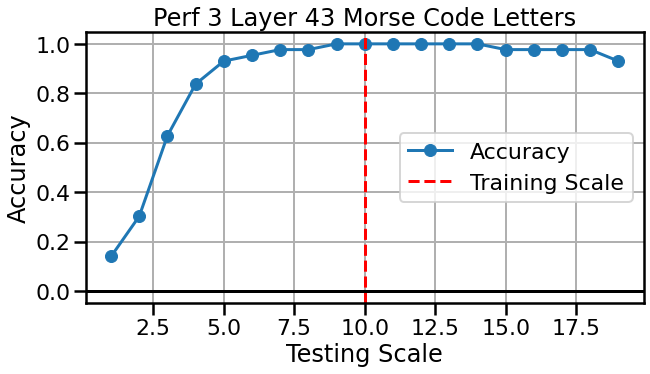

In [24]:
fig=plt.figure(figsize=(10,5))
plt.plot([e[0] for e in evald],
         [e[1] for e in evald],
         marker='o');

plt.axvline(Trainscale, color='red', linestyle='--')
plt.axhline(0, color='black')
plt.ylim(-.05, 1.05)
plt.grid()
plt.title('Perf 3 Layer 43 Morse Code Letters')
plt.ylabel('Accuracy')
plt.xlabel('Testing Scale')
plt.legend(['Accuracy', 'Training Scale'])